In [1]:
import os, sys
sys.path.append("src/")
os.environ["CUDA_VISIBLE_DEVICES"] = "2,"
from types import SimpleNamespace
import math
import numpy as np
from einops import rearrange
from PIL import Image, ImageDraw
import torch

from musubi_tuner.dataset.image_video_dataset import resize_image_to_bucket
from musubi_tuner.networks import lora_framepack
from musubi_tuner.frame_pack.uni_pc_fm import sample_unipc
from musubi_tuner.frame_pack.wrapper import fm_wrapper
from musubi_tuner.frame_pack.clip_vision import hf_clip_vision_encode
from musubi_tuner.frame_pack.framepack_utils import load_vae, load_text_encoder1, load_text_encoder2, load_image_encoders
from musubi_tuner.frame_pack.hunyuan import encode_prompt_conds, vae_encode, vae_decode
from musubi_tuner.frame_pack.hunyuan_video_packed import load_packed_model
# from musubi_tuner.frame_pack.k_diffusion_hunyuan import sample_hunyuan
from musubi_tuner.frame_pack.utils import crop_or_pad_yield_mask
from musubi_tuner.wan_generate_video import merge_lora_weights

device = torch.device('cuda')

2025-07-15 16:50:38.002045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752565838.020661   58022 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752565838.026456   58022 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-15 16:50:38.108347: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:numexpr.utils:Note: detected 96 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment 

Xformers is installed!
Flash Attn is installed!
Sage Attn is installed!
Trying to import sageattention
Successfully imported sageattention


In [2]:
dit_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors"
vae_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/VAE/hunyuan-video-t2v-720p-vae.pt"
text_encoder1_path = "/shared/video/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors"
text_encoder2_path = "/shared/video/ComfyUI/models/text_encoders/clip_l.safetensors"
image_encoder_path = "/shared/video/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors"
# lora_path = "/data/stale/patrickkwon/video/stable-diffusion-webui/models/Lora/framepack/fpack_1fmc_bg_lora/bg_lora_1000.safetensors"
lora_path = "/data/whisperer/related/framepackbase/musubi-tuner/outputs/training/posecontrol_lora/posecontrol_lora_test1.safetensors"

model = load_packed_model(device, dit_path, 'sageattn', device)
model.to(device)
model.eval().requires_grad_(False)
# model.move_to_device_except_swap_blocks(device)
# model.prepare_block_swap_before_forward()
merge_lora_weights(lora_framepack, model, 
    SimpleNamespace(
        lora_weight = [lora_path], 
        lora_multiplier = [1.0], 
        include_patterns=None, 
        exclude_patterns=None, 
        lycoris=None,
        save_merged_model=False), 
device, None)

vae = load_vae(vae_path, 32, 128, device)

tokenizer1, text_encoder1 = load_text_encoder1(SimpleNamespace(text_encoder1=text_encoder1_path), False, device)
tokenizer2, text_encoder2 = load_text_encoder2(SimpleNamespace(text_encoder2=text_encoder2_path))
feature_extractor, image_encoder = load_image_encoders(SimpleNamespace(image_encoder=image_encoder_path))

INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Creating HunyuanVideoTransformer3DModelPacked
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loading DiT model from /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors, device=cuda
INFO:musubi_tuner.frame_pack.hunyuan_video_packed:Loaded DiT model from /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors, info=<All keys matched successfully>
INFO:musubi_tuner.wan_generate_video:Loading LoRA weights from /data/whisperer/related/framepackbase/musubi-tuner/outputs/training/posecontrol_lora/posecontrol_lora_test1.safetensors with multiplier 1.0
INFO:musubi_tuner.networks.lora:create LoRA network from weights
INFO:musubi_tuner.networks.lora:create LoRA for U-Net/DiT: 440 modules.
INFO:musubi_tuner.networks.lora:weights are merged
INFO:musubi_tuner.wan_generate_video:LoRA weights loaded
INFO:musubi_tuner.hunyuan_model.vae:Loading 3D VAE model (

In [15]:
# prompt = 'The girl in a school blazer in a classroom.'
# height, width = 832, 480
# image_path = "docs/kisekaeichi_start.png"
# control_image_paths = ["docs/kisekaeichi_start.png", "docs/kisekaeichi_ref.png"]
# control_image_mask_paths = ["docs/kisekaeichi_start_mask.png", "docs/kisekaeichi_ref_mask.png"]
# one_frame_inference = {'control_index=0;10', 'no_2x', 'no_4x', 'no_post', 'target_index=1'}

# prompt = "An anime-style girl wearing a school uniform and ribbon tie is walking along the seaside from a distance."
# height, width = 480, 480
# image_path = "docs/bg_sample.png"
# target_index = [1]
# control_image_paths = ["docs/bg_sample.png", "docs/fg_sample.jpg"]
# control_image_mask_paths = ["docs/bg_sample_mask.png", ""]
# control_indices = [0,10]

# prompt = 'Chinese Ancient Wuxia. The red-clothed maiden and the burly man engage in a fierce battle on the stage. The maiden moves gracefully with agile techniques, while the man is strong and powerful. The surrounding crowd cheers excitedly.'
# height, width = 336, 672
# image_path = "outputs/vistory_tmp/vistory_04_04_bg.png"
# target_index = [1]
# control_image_paths = ["outputs/vistory_tmp/vistory_04_04_bg.png", "outputs/vistory_tmp/vistory_04_04_chara.png"]
# control_image_mask_paths = ["outputs/vistory_tmp/vistory_04_04_mask.png", ""]
# control_indices = [0,10]

prompt = 'Dancing tiktok video'
height, width = 960, 544
image_path = "/data/whisperer/datasets/pose/tiktok_train/controls/cond1/00307_images_0118.png"
target_index = [1]
control_image_paths = [
    # "/data/ai-video/datasets/AnimeDrawingsDataset/images_raw/train/1164056.png", 
    # "/data/ai-video/datasets/AnimeDrawingsDataset/images_raw/train/1164861.png",
    "/data/whisperer/datasets/pose/tiktok_train/controls/cond1/00307_images_0118.png",
    "/data/whisperer/datasets/pose/tiktok_train/controls/cond2/00307_images_0273.png"
]
control_image_mask_paths = ["", ""]
control_indices = [0,10]

In [4]:
# img_tensor, img_np = preproc_image(image_path)

# tmp_img = Image.new("L", (width, height), 255,)
# coords = [0.45, 0.5, 0.6, 0.8]
# draw = ImageDraw.Draw(tmp_img)
# draw.rectangle(
#     (int(coords[0]*width), int(coords[1]*height), int(coords[2]*width), int(coords[3]*height)), 
#     0
# )

# tmp_img.save('docs/bg_sample_mask.png')
# Image.fromarray(np.concatenate([img_np, 255-np.asarray(tmp_img)[...,None]], axis=-1).astype(np.uint8))

### prepare_i2v_inputs --> prepare_text_inputs

In [9]:
with torch.autocast(device_type=device.type, dtype=text_encoder1.dtype), torch.no_grad():
    llama_vec, clip_l_pooler = encode_prompt_conds(
        prompt, text_encoder1, text_encoder2, tokenizer1, tokenizer2, custom_system_prompt=None
    )
    llama_vec = llama_vec.to(device, dtype=torch.bfloat16)
    clip_l_pooler = clip_l_pooler.to(device, dtype=torch.bfloat16)
    llama_vec, llama_attention_mask = crop_or_pad_yield_mask(llama_vec, length=512)

llama_vec_n = torch.zeros_like(llama_vec).to(device, dtype=torch.bfloat16)
clip_l_pooler_n  = torch.zeros_like(clip_l_pooler).to(device, dtype=torch.bfloat16)
llama_vec_n, llama_attention_mask_n = crop_or_pad_yield_mask(llama_vec_n, length=512)

### prepare_i2v_inputs --> prepare_img_inputs

In [16]:
# preprocess image:
def preproc_image(image_path):
    image_pil = Image.open(image_path).convert("RGB")
    image_np = resize_image_to_bucket(np.array(image_pil), (width, height))
    image_tensor = (torch.from_numpy(image_np).float() / 127.5 - 1.0).permute(2,0,1)[None, :, None]
    return image_tensor, image_np

def preproc_mask(mask_path):
    if mask_path == '':
        image_pil = Image.new("L", (width // 8, height // 8), 255)
    else:
        image_pil = Image.open(mask_path).convert("L")
    image_np = resize_image_to_bucket(np.array(image_pil), (width // 8, height // 8))
    image_tensor = (torch.from_numpy(image_np).float() / 255.0)[None, None, None, :, :]
    return image_tensor, image_np

img_tensor, img_np = preproc_image(image_path)
with torch.no_grad():
    image_encoder_output = hf_clip_vision_encode(img_np, feature_extractor, image_encoder)
image_encoder_last_hidden_state = image_encoder_output.last_hidden_state.to(device, dtype=torch.bfloat16)
# start_latent = vae_encode(img_tensor, vae).cpu()

latent_indices = torch.tensor([target_index], dtype=torch.int64)  # 1x1 latent index for target image

control_latents, control_nps = [], []
for i, (control_image_path, control_mask_path) in enumerate(zip(control_image_paths, control_image_mask_paths)):
    c_img_tensor, c_img_np = preproc_image(control_image_path)
    c_img_latent = vae_encode(c_img_tensor, vae).cpu()
    
    c_mask_image, c_mask_np = preproc_mask(control_mask_path)
    c_img_latent = c_img_latent * c_mask_image
    control_latents.append(c_img_latent)
    control_nps.append(np.concatenate([c_img_np, resize_image_to_bucket(c_mask_np, (width, height))[..., None]], -1))
clean_latents = torch.cat(control_latents, dim=2)  # (1, 16, num_control_images, H//8, W//8)

clean_latent_indices = torch.tensor([control_indices], dtype=torch.int64)

### sample_hunyuan

  0%|          | 0/25 [00:00<?, ?it/s]

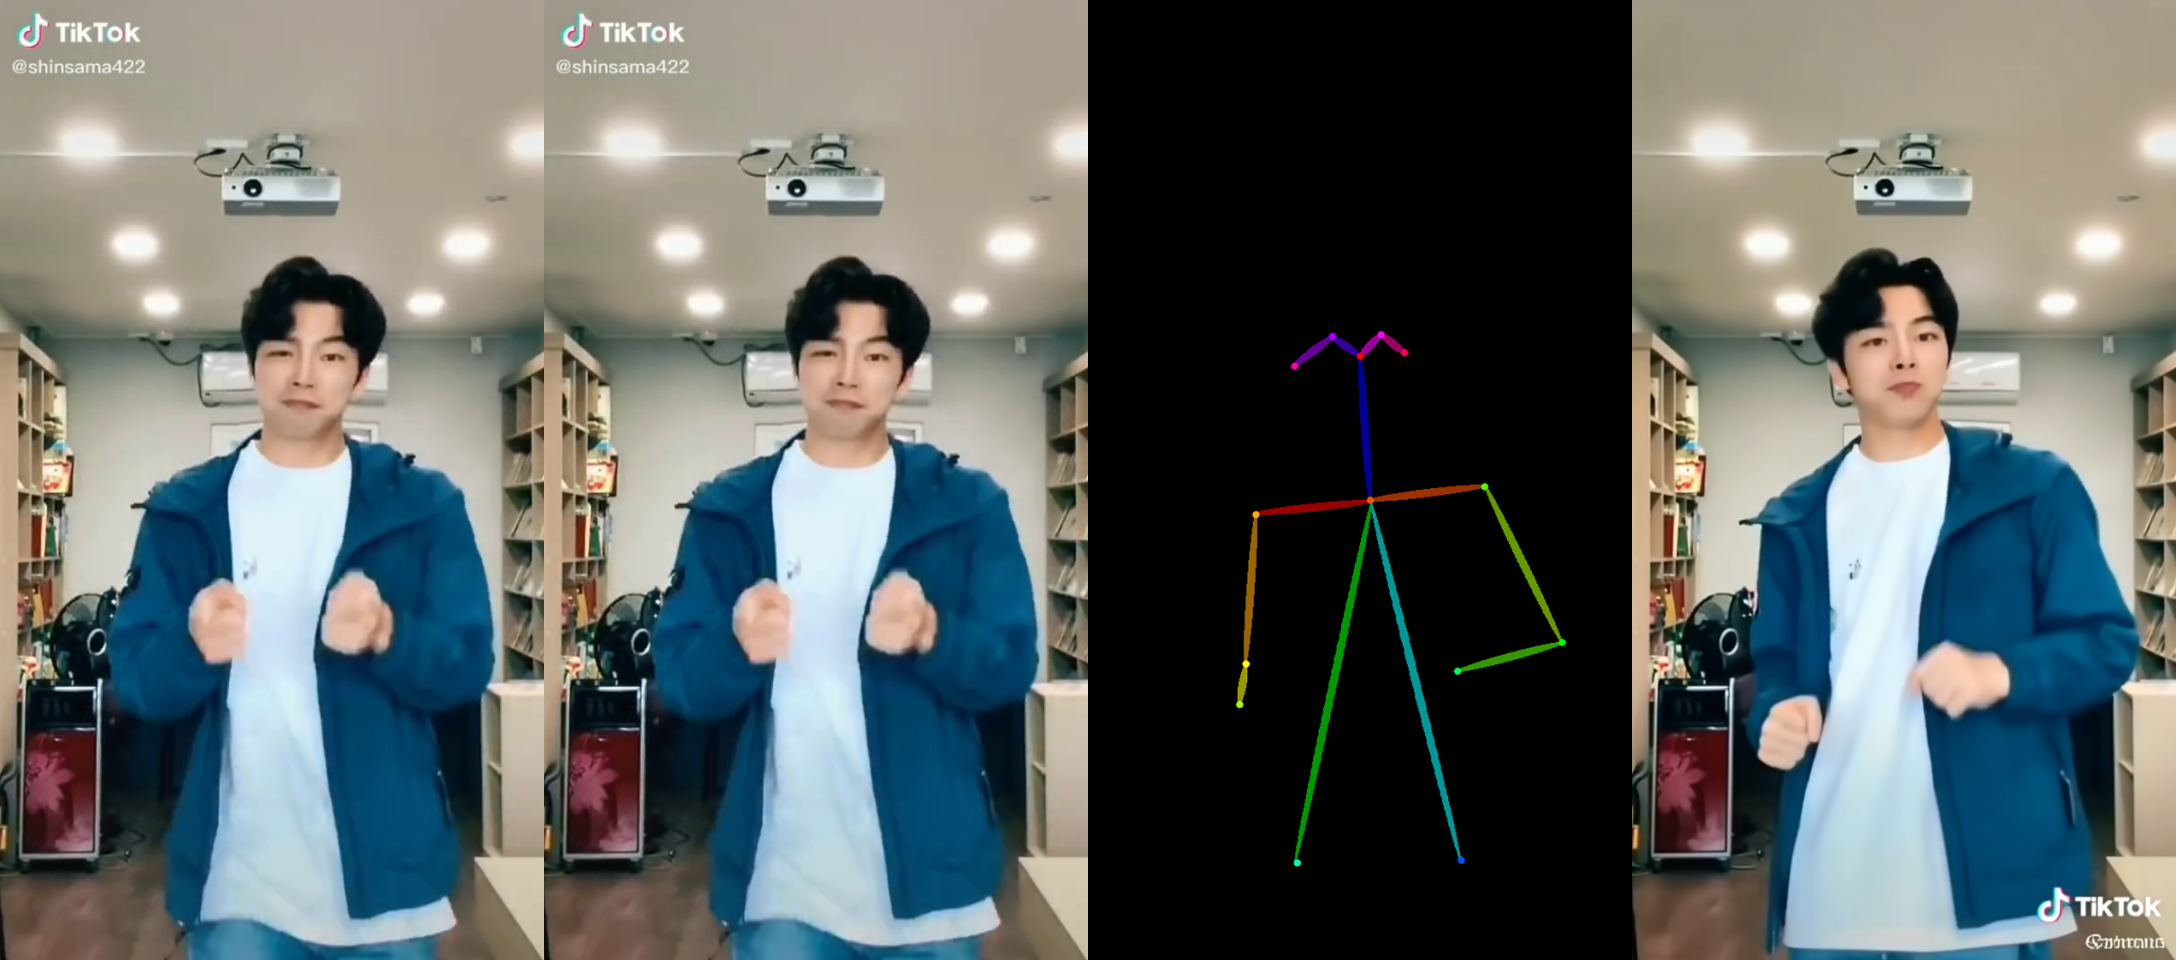

In [17]:
def flux_time_shift(t, mu=1.15, sigma=1.0):
    return math.exp(mu) / (math.exp(mu) + (1 / t - 1) ** sigma)

def calculate_flux_mu(context_length, x1=256, y1=0.5, x2=4096, y2=1.15, exp_max=7.0):
    k = (y2 - y1) / (x2 - x1)
    b = y1 - k * x1
    mu = k * context_length + b
    mu = min(mu, math.log(exp_max))
    return mu

def get_flux_sigmas_from_mu(n, mu):
    sigmas = torch.linspace(1, 0, steps=n + 1)
    sigmas = flux_time_shift(sigmas, mu=mu)
    return sigmas

real_guidance_scale=1.0
distilled_guidance_scale=10.0
guidance_rescale=0.0
num_inference_steps=25
seed = 48
generator = torch.Generator(device="cpu")
generator.manual_seed(seed)

latents = torch.randn((1, 16, 1, height // 8, width // 8), generator=generator).to(device=device, dtype=torch.float32)
seq_length = (height * width) // 256
mu = calculate_flux_mu(seq_length, exp_max=7.0) # math.log(shift) 1.9459... if seq_len is large, mu is clipped.
sigmas = get_flux_sigmas_from_mu(num_inference_steps, mu).to(device)

k_model = fm_wrapper(model)

distilled_guidance = torch.tensor([distilled_guidance_scale * 1000.0]).to(device=device, dtype=torch.bfloat16)
sampler_kwargs = dict(
    dtype=torch.bfloat16,
    cfg_scale=real_guidance_scale,
    cfg_rescale=guidance_rescale,
    concat_latent=None,
    positive=dict(
        pooled_projections=clip_l_pooler,
        encoder_hidden_states=llama_vec,
        encoder_attention_mask=llama_attention_mask,
        guidance=distilled_guidance,

        image_embeddings=image_encoder_last_hidden_state,
        latent_indices=latent_indices,
        clean_latents=clean_latents,
        clean_latent_indices=clean_latent_indices,
        clean_latents_2x=None,
        clean_latent_2x_indices=None,
        clean_latents_4x=None,
        clean_latent_4x_indices=None
    ),
    negative=dict(
        pooled_projections=clip_l_pooler_n,
        encoder_hidden_states=llama_vec_n,
        encoder_attention_mask=llama_attention_mask_n,
        guidance=distilled_guidance,

        image_embeddings=image_encoder_last_hidden_state,
        latent_indices=latent_indices,
        clean_latents=clean_latents,
        clean_latent_indices=clean_latent_indices,
        clean_latents_2x=None,
        clean_latent_2x_indices=None,
        clean_latents_4x=None,
        clean_latent_4x_indices=None
    ),
)

results = sample_unipc(k_model, latents, sigmas, extra_args=sampler_kwargs, disable=False, callback=None)

history_pixels = torch.cat([
    vae_decode(results[:, :, i:i + 1, :, :], vae).cpu() for i in range(results.shape[2])
], dim=2)
result_img = (torch.clamp(((history_pixels[0,:,0,:,:]+1.0)/2.0).permute(1,2,0).cpu(), 0.0, 1.0) * 255.).numpy().astype(np.uint8)

Image.fromarray(np.concatenate(
    [np.concatenate([img_np, np.ones(img_np.shape[:2] + (1, ))*255], axis=-1).astype(np.uint8)] + \
    control_nps + \
    [np.concatenate([result_img, np.ones(result_img.shape[:2] + (1, ))*255], axis=-1).astype(np.uint8)], 
axis=1))

```bash
python fpack_generate_video.py \
    --video_size 832 480 \
    --video_sections 1 \
    --infer_steps 25 \
    --prompt "The girl in a school blazer in a classroom." \
    --save_path outputs/ \
    --output_type latent_images \
    --dit /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors \
    --vae /data/stale/patrickkwon/video/stable-diffusion-webui/models/VAE/hunyuan-video-t2v-720p-vae.pt \
    --text_encoder1 /shared/video/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors \
    --text_encoder2 /shared/video/ComfyUI/models/text_encoders/clip_l.safetensors \
    --image_encoder /shared/video/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors \
    --attn_mode sageattn \
    --vae_spatial_tile_sample_min_size 128 \
    --vae_chunk_size 32 \
    --image_path docs/kisekaeichi_start.png \
    --control_image_path docs/kisekaeichi_start.png docs/kisekaeichi_ref.png \
    --one_frame_inference 'target_index=1,control_index=0;10,no_2x,no_4x,no_post' \
    --control_image_mask_path docs/kisekaeichi_start_mask.png docs/kisekaeichi_ref_mask.png \
    --seed 1234
```

```bash
python fpack_generate_video.py \
 --video_size 480 480 \
 --video_sections 1 \
 --infer_steps 25 \
 --prompt "An anime-style girl wearing a school uniform and ribbon tie is walking along the seaside from a distance." \
 --save_path outputs/ \
 --output_type latent_images \
 --dit /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors \
 --vae /data/stale/patrickkwon/video/stable-diffusion-webui/models/VAE/hunyuan-video-t2v-720p-vae.pt \
 --text_encoder1 /shared/video/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors \
 --text_encoder2 /shared/video/ComfyUI/models/text_encoders/clip_l.safetensors \
 --image_encoder /shared/video/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors \
 --attn_mode sdpa \
 --vae_spatial_tile_sample_min_size 128 \
 --vae_chunk_size 32 \
 --image_path docs/bg_sample.png \
 --control_image_path docs/bg_sample.png docs/fg_sample.jpg \
 --one_frame_inference 'target_index=1,control_index=0;10,no_2x,no_4x,no_post' \
 --seed 1234 \
 --lora_weight /data/stale/patrickkwon/video/stable-diffusion-webui/models/Lora/framepack/fpack_1fmc_bg_lora/bg_lora_1000.safetensors \
 --lora_multiplier 1.0 \
```

/data/whisperer/related/framepackbase/musubi-tuner
```bash
python fpack_cache_latents.py \
    --dataset_config /lustre/fs1/groups/chenchen/patrick/OpenS2V-Nexus/datasets/OpenS2V_part1_test3_2.toml \
    --vae /lustre/fs1/home/yo564250/workspace/ComfyUI/models/vae/hunyuan-video-t2v-720p-vae.pt \
    --image_encoder /lustre/fs1/home/yo564250/workspace/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors \
    --vae_chunk_size 32 --vae_spatial_tile_sample_min_size 128 \
    --skip_existing --keep_cache \
    --one_frame --one_frame_no_2x --one_frame_no_4x

python fpack_cache_text_encoder_outputs.py \
    --dataset_config /groups/chenchen/patrick/OpenS2V-Nexus/datasets/OpenS2V_part1_test3_2.toml \
    --text_encoder1 /home/yo564250/workspace/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors \
    --text_encoder2 /home/yo564250/workspace/ComfyUI/models/text_encoders/clip_l.safetensors \
    --batch_size 16
```

```bash
accelerate launch --num_cpu_threads_per_process 1 --mixed_precision bf16 fpack_train_network.py \
    --dit /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors \
    --vae /data/stale/patrickkwon/video/stable-diffusion-webui/models/VAE/hunyuan-video-t2v-720p-vae.pt \
    --text_encoder1 /shared/video/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors \
    --text_encoder2 /shared/video/ComfyUI/models/text_encoders/clip_l.safetensors \
    --image_encoder /shared/video/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors \
    --dataset_config /data/whisperer/datasets/pose/tiktok_train/train.toml \
    --sdpa --mixed_precision bf16 --one_frame \
    --optimizer_type adamw8bit --learning_rate 2e-4 --gradient_checkpointing \
    --timestep_sampling shift --weighting_scheme none --discrete_flow_shift 3.0 \
    --max_data_loader_n_workers 8 --persistent_data_loader_workers \
    --network_module networks.lora_framepack --network_dim 32 \
    --max_train_epochs 16 --save_every_n_epochs 1 --seed 42 \
    --sample_prompts /data/whisperer/datasets/pose/tiktok_train/sample_prompts.txt \
    --sample_every_n_epochs 1 --sample_at_first \
    --output_dir outputs/training/posecontrol_lora --output_name posecontrol_lora_test1 \
    --logging_dir outputs/training/posecontrol_lora/logs --log_with tensorboard
```

Dancing tiktok video 
--i /data/whisperer/datasets/pose/tiktok_train/controls/cond1/00301_images_0225.png
--ci /data/whisperer/datasets/pose/tiktok_train/controls/cond1/00301_images_0225.png
--ci /data/whisperer/datasets/pose/tiktok_train/controls/cond2/00301_images_0280.png
--of target_index=1,control_index=0;10,no_2x,no_4x,no_post
--d 1111 --f 1 --s 25 --w 544 --h 960



accelerate launch --num_cpu_threads_per_process 1 --mixed_precision bf16 fpack_train_network.py \
--dit /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors \
--vae /data/stale/patrickkwon/video/stable-diffusion-webui/models/VAE/hunyuan-video-t2v-720p-vae.pt \
--text_encoder1 /shared/video/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors \
--text_encoder2 /shared/video/ComfyUI/models/text_encoders/clip_l.safetensors \
--image_encoder /shared/video/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors \
--dataset_config /data/whisperer/datasets/storyviz/OpenS2V-Nexus/datasets/test2/train.toml \
--sdpa --mixed_precision bf16 --one_frame \
--optimizer_type adamw8bit --learning_rate 2e-4 --gradient_checkpointing \
--timestep_sampling shift --weighting_scheme none --discrete_flow_shift 3.0 \
--max_data_loader_n_workers 8 --persistent_data_loader_workers \
--network_module networks.lora_framepack --network_dim 32 \
--max_train_epochs 8 --save_every_n_epochs 1 --seed 42 \
--sample_prompts /data/whisperer/datasets/storyviz/OpenS2V-Nexus/datasets/test2/sample_prompts.txt \
--sample_every_n_steps 1000 --sample_at_first \
--output_dir outputs/training/s2vnexus_posecontrol_lora --output_name lora_test1 \
--logging_dir outputs/training/s2vnexus_posecontrol_lora/logs --log_with tensorboard

In [ ]:
import os, sys
sys.path.append("src/")
entry_string = """python fpack_train_network.py \
--dit /data/stale/patrickkwon/video/stable-diffusion-webui/models/Hunyuan/FramePackI2V_HY_bf16.safetensors \
--vae /data/stale/patrickkwon/video/stable-diffusion-webui/models/VAE/hunyuan-video-t2v-720p-vae.pt \
--text_encoder1 /shared/video/ComfyUI/models/text_encoders/llava_llama3_fp16.safetensors \
--text_encoder2 /shared/video/ComfyUI/models/text_encoders/clip_l.safetensors \
--image_encoder /shared/video/ComfyUI/models/clip_vision/sigclip_vision_patch14_384.safetensors \
--dataset_config /data/whisperer/datasets/storyviz/OpenS2V-Nexus/datasets/test2/train.toml \
--sdpa --mixed_precision bf16 --one_frame \
--optimizer_type adamw8bit --learning_rate 2e-4 --gradient_checkpointing \
--timestep_sampling shift --weighting_scheme none --discrete_flow_shift 3.0 \
--max_data_loader_n_workers 8 --persistent_data_loader_workers \
--network_module networks.lora_framepack --network_dim 32 \
--max_train_epochs 16 --save_every_n_epochs 1 --seed 42 \
--sample_prompts /data/whisperer/datasets/storyviz/OpenS2V-Nexus/datasets/test2/sample_prompts.txt \
--sample_every_n_epochs 1 --sample_at_first \
--output_dir outputs/training/posecontrol_lora --output_name posecontrol_lora_test4 \
--logging_dir outputs/training/posecontrol_lora/logs --log_with tensorboard"""
sys.argv = entry_string.split(" ")[1:]
import argparse
from pathlib import Path

from musubi_tuner.hv_train_network import setup_parser_common, read_config_from_file
from musubi_tuner.fpack_train_network import framepack_setup_parser

parser = setup_parser_common()
parser = framepack_setup_parser(parser)

args = parser.parse_args()
args = read_config_from_file(args, parser)

assert (
    args.vae_dtype is None or args.vae_dtype == "float16"
), "VAE dtype must be float16 / VAEのdtypeはfloat16でなければなりません"
args.vae_dtype = "float16"  # fixed
args.dit_dtype = "bfloat16"  # fixed
args.sample_solver = "unipc"  # for sample generation, fixed to unipc

for k, v in vars(args).items():
    print(f"{k} = {v}")

config_file = None
dataset_config = /data/whisperer/datasets/storyviz/OpenS2V-Nexus/datasets/test2/train.toml
sdpa = True
flash_attn = False
sage_attn = False
xformers = False
flash3 = False
split_attn = False
max_train_steps = 1600
max_train_epochs = 16
max_data_loader_n_workers = 8
persistent_data_loader_workers = True
seed = 42
gradient_checkpointing = True
gradient_accumulation_steps = 1
mixed_precision = bf16
logging_dir = outputs/training/posecontrol_lora/logs
log_with = tensorboard
log_prefix = None
log_tracker_name = None
wandb_run_name = None
log_tracker_config = None
wandb_api_key = None
log_config = False
ddp_timeout = None
ddp_gradient_as_bucket_view = False
ddp_static_graph = False
sample_every_n_steps = None
sample_at_first = True
sample_every_n_epochs = 1
sample_prompts = /data/whisperer/datasets/pose/tiktok_train/sample_prompts.txt
optimizer_type = adamw8bit
optimizer_args = None
learning_rate = 0.0002
max_grad_norm = 1.0
lr_scheduler = constant
lr_warmup_steps = 0
lr_d